In [1]:
import os
import time

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from dotenv import load_dotenv
from IPython.display import clear_output
from tqdm import tqdm

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score

from qiskit.circuit.library import real_amplitudes, zz_feature_map, efficient_su2, n_local
from qiskit import generate_preset_pass_manager

from qiskit_aer import AerSimulator

from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import Sampler

from qiskit_machine_learning.optimizers import COBYLA
from qiskit_machine_learning.algorithms.classifiers import VQC

In [3]:
phone = pd.read_csv('data/cleaned/cleaned_data.csv')

In [5]:
phone

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,...,20,756,2549,9,7,19,0,0,1,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,...,905,1988,2631,17,3,7,1,1,0,2
2,563,1,0.5,1,2,1,41,0.9,145,5,...,1263,1716,2603,11,2,9,1,1,0,2
3,615,1,2.5,0,0,0,10,0.8,131,6,...,1216,1786,2769,16,8,11,1,0,0,2
4,1821,1,1.2,0,13,1,44,0.6,141,2,...,1208,1212,1411,8,2,15,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1993,794,1,0.5,1,0,1,2,0.8,106,6,...,1222,1890,668,13,4,19,1,1,0,0
1994,1965,1,2.6,1,0,0,39,0.2,187,4,...,915,1965,2032,11,10,16,1,1,1,2
1995,1911,0,0.9,1,1,1,36,0.7,108,8,...,868,1632,3057,9,1,5,1,1,0,3
1996,1512,0,0.9,0,4,1,46,0.1,145,5,...,336,670,869,18,10,19,1,1,1,0


# Les modèles quantiques

Nous allons maintenant développer un modèle d'intelligence artificielle quantique. Nous allons nous concentrer sur la Variational Quantum Classifier (VQC) de la bibliothèque `qiskit-machine-learning`. Commençons par discuter des données.

## Travail des données

### Filtrage des données

Il ne va pas être possible d'utiliser l'intégralité des données pour entraîner le modèle quantique. Nous allons nous concentrer sur les données les plus corrélées afin de limiter le nombre d'attributs sur lequels nous voulons construire le modèle. La raison principale est que nous voulons utiliser le minimum de qubits possible afin de limiter les erreurs dans le circuit.

Nous avons vu dans l'analyse de données que les données les plus corrélées étaient `ram` et `battery_power`.

In [7]:
data = phone[['ram', 'battery_power', 'price_range', 'px_height', 'px_width']].copy()
data['nb_of_px'] = data['px_height'] * data['px_width']
data = data.drop(columns=['px_height', 'px_width'])
data

,ram,battery_power,price_range,nb_of_px
0,2549,842,1,15120
1,2631,1021,2,1799140
2,2603,563,2,2167308
3,2769,615,2,2171776
4,1411,1821,1,1464096
...,...,...,...,...
1993,668,794,0,2309580
1994,2032,1965,2,1797975
1995,3057,1911,3,1416576
1996,869,1512,0,225120


### Normalisation des données

En informatique quantique, il est préférable de normaliser les données avant de les utiliser pour entraîner un modèle. Nous allons faire une normalisation Min-Max pour commencer.

In [9]:
X = data.drop(columns=['price_range'])
y = data['price_range']

X = pd.DataFrame(MinMaxScaler().fit_transform(X), columns=X.columns)

Nous allons maintenant créer notre premier modèle quantique.

### Création du modèle quantique

Pour que la VQC fonctionne elle a besoin de plusieurs éléments :
- Un sampler : un échantillonneur quantique qui exécute le circuit quantique et récupère les résultats.
- Un ansatz : un circuit quantique paramétré qui sera optimisé pendant l'entraînement.
- Un feature map : une transformation quantique qui encode les données classiques dans l'espace quantique.
- Un optimiseur : un algorithme d'optimisation pour ajuster les paramètres du circuit.
- Un callback : une fonction qui sera appelée à chaque itération de l'optimisation pour suivre les progrès.

Commençons par le feature map.

#### Le Feature Map

Nous avons deux attributs dans nos données, ce qui constituera la base de notre circuit. Il y a plusieurs types archétypes de feature maps, nous utiliserons dans un premier temps le `ZZFeatureMap` qui est un classique pour encoder les données.

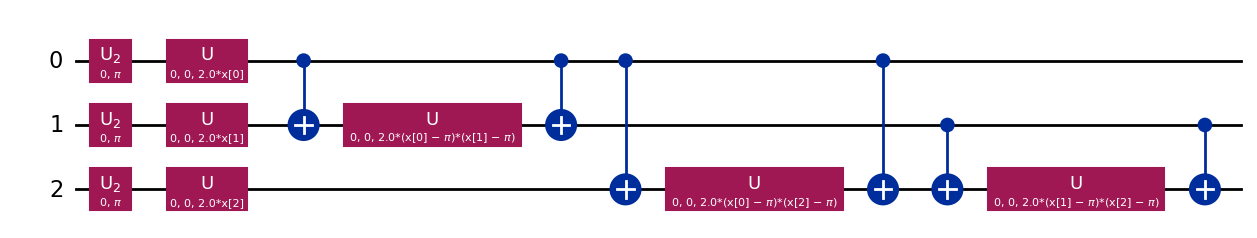

In [11]:
feature_dimension = X.shape[1]

feature_map = zz_feature_map(feature_dimension=feature_dimension, reps=1, entanglement='full')

feature_map.decompose().draw("mpl")

Le nombre de répétitions du circuit ainsi que l'intrication font partie des hyperparamètres que nous allons pouvoir ajuster afin d'améliorer les performances du modèle. Dans un premier temps, nous allons utiliser des valeurs simples. Nous pourrons aussi potentiellement changer le circuit pour le `feature map` pour chercher à optimiser le modèle.

#### L'ansatz

Intéressons maintenant de plus près à l'ansatz. L'ansatz est un circuit quantique paramétré qui sera optimisé pendant l'entraînement. Ici aussi, il existe plusieurs archétypes de circuits que nous pourrions utiliser. Nous allons commencer par utiliser le `RealAmplitudes` qui est un circuit quantique simple et efficace pour les problèmes de classification.

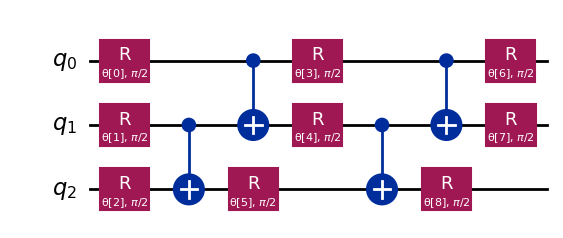

In [13]:
ansatz = real_amplitudes(num_qubits=feature_dimension, reps=2)
ansatz.decompose().draw(output="mpl")

Le nombre de paramètres du circuit va correspondre aux poids des portes quantiques que nous allons optimiser pendant l'entraînement. Nous avons plusieurs hyperparamètres possibles également pour ce circuit, mais afin de limiter la profondeur du circuit, nous nous limitons à deux répétitions.

#### L'optimiseur

La librairie `qiskit-machine-learning` propose plusieurs optimiseurs.

https://qiskit-community.github.io/qiskit-machine-learning/apidocs/qiskit_machine_learning.optimizers.html

Nous allons utiliser COBYLA, il sera intéressant de comparer les performances avec d'autres optimiseurs par la suite.

In [15]:
optimizer = COBYLA(maxiter=100)

#### La primitive

Nous allons utiliser un Sampler pour exécuter le circuit quantique et récupérer les résultats. Dans un premier temps, nous allons utiliser un simulateur quantique à partir de l'ordinateur Torino qui a le QPU qui a le plus faible taux d'erreur. Le fait de déterminer tout de suite quel ordinateur quantique nous allons utiliser va permettre d'optimiser le `pass manager` afin d'obtenir le circuit le plus optimisé et donc avec le moins d'erreurs possible.

Avant d'exécuter le circuit sur un QPU, nous allons utiliser un simulateur quantique pour tester le circuit et vérifier qu'il fonctionne correctement. Il est possible avec Qiskit de simuler un QPU spécifiquer grâce à la classe `AerSimulator`. L'ordinateur quantique que nous utiliserons est Torino.

In [17]:
load_dotenv('local.env')

token = os.getenv('IBM_TOKEN')
instance = os.getenv('IBM_INSTANCE')

QiskitRuntimeService.save_account(
    token=token,
    instance=instance,
    set_as_default=True,
    overwrite=True
)

service = QiskitRuntimeService()
backend = service.backend("ibm_torino")

# Défintion d'un simulateur qui a les mêmes propriétés que l'ordinateur quantique
fake_backend = AerSimulator.from_backend(backend)

Une fois que nous avons récupéré un backend de simulation nous pouvons l'utiliser pour l'associer au `sampler` qui va exécuter le circuit quantique et récupérer les résultats.

In [18]:
sampler = Sampler(mode=fake_backend)

Nous allons également créer un `pass manager` qui va optimiser le circuit en circuit ISA avant de l'exécuter sur le QPU.

In [19]:
pass_manager = generate_preset_pass_manager(
    backend=fake_backend,
    optimization_level=0,
)

Ici aussi, il existe plusieurs niveaux d'optimisation qui correspondent aux différentes étapes de la transpilation. Nous allons d'abord partir d'un élément simple avant de l'affiner au fur et à mesure. Le paramètre `optimization_level` est choisi à 0 afin de ne pas avoir du tout de correction d'erreur.

#### Graphiques

La classe VQC permet de passer en paramètre une callback. Nous allons utiliser cette callback pour pouvoir voir l'évolution de l'entraînement et l'optimisation de notre modèle.

In [20]:
plt.rcParams["figure.figsize"] = (12, 6)

In [25]:
def callback_graph(weights, obj_func_eval):
    """
    args:
        weights: Poids calculés
        obj_func_eval: Valeur de la fonction objective
    return: None
    """
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Valeur de la fonction objective en fonction de l'itération")
    plt.xlabel("Itération")
    plt.ylabel("Valeur de la fonction objective")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

Nous passerons cette fonction au modèle afin de suivre l'évolution de l'optimisation.

## Entraînement du premier modèle

Nous allons entraîner notre premier modèle avec des paramètres déterminés de manière arbitraire. L'objectif ici n'est pas d'obtenir tout de suite le meilleur modèle possible, mais de faire tourner un premier modèle pour mettre ensuite en oeuvre une réflexion autour de l'optimisation.

Nous allons dans un premier temps séparer les données.

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.80)

Transpilons maintenant la `feature map` afin d'analyser le circuit qui va être exécuté sur le backend.

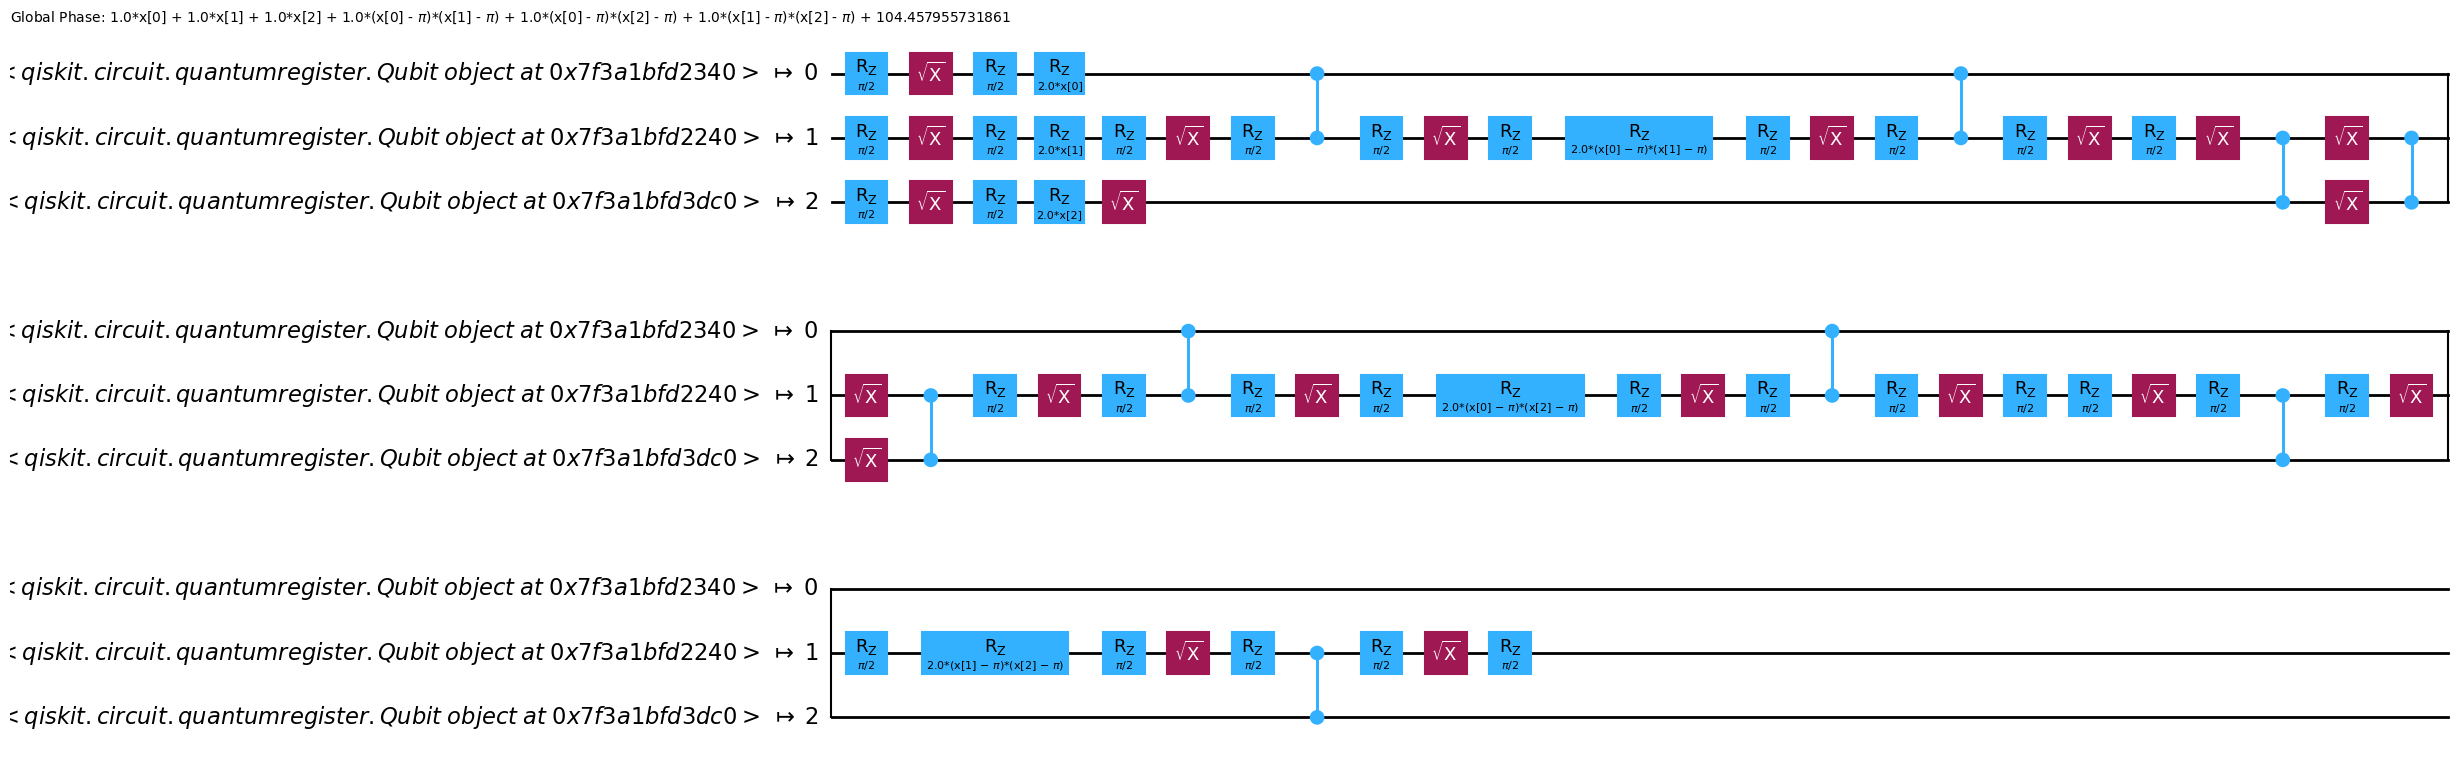

In [29]:
isa_circuit = pass_manager.run(feature_map)
isa_circuit.draw(output="mpl", idle_wires=False)

In [31]:
print("Profondeur du circuit:", isa_circuit.depth())
print("Taille du circuit:", isa_circuit.size())

Profondeur du circuit: 55
Taille du circuit: 66


Le circuit a été limité de manière volontaire à deux qubits afin de limiter les erreurs de l'ordinateur. Le fait qu'il ne soit pas trop grand est aussi un avantage pour nous. Il est à noter que le `pass_manager` utilisé n'a pas d'optimisation pour le moment. Nous en ajouterons par la suite lors de la recherche de paramètres optimaux.

Analysons de la même manière l'ansatz.

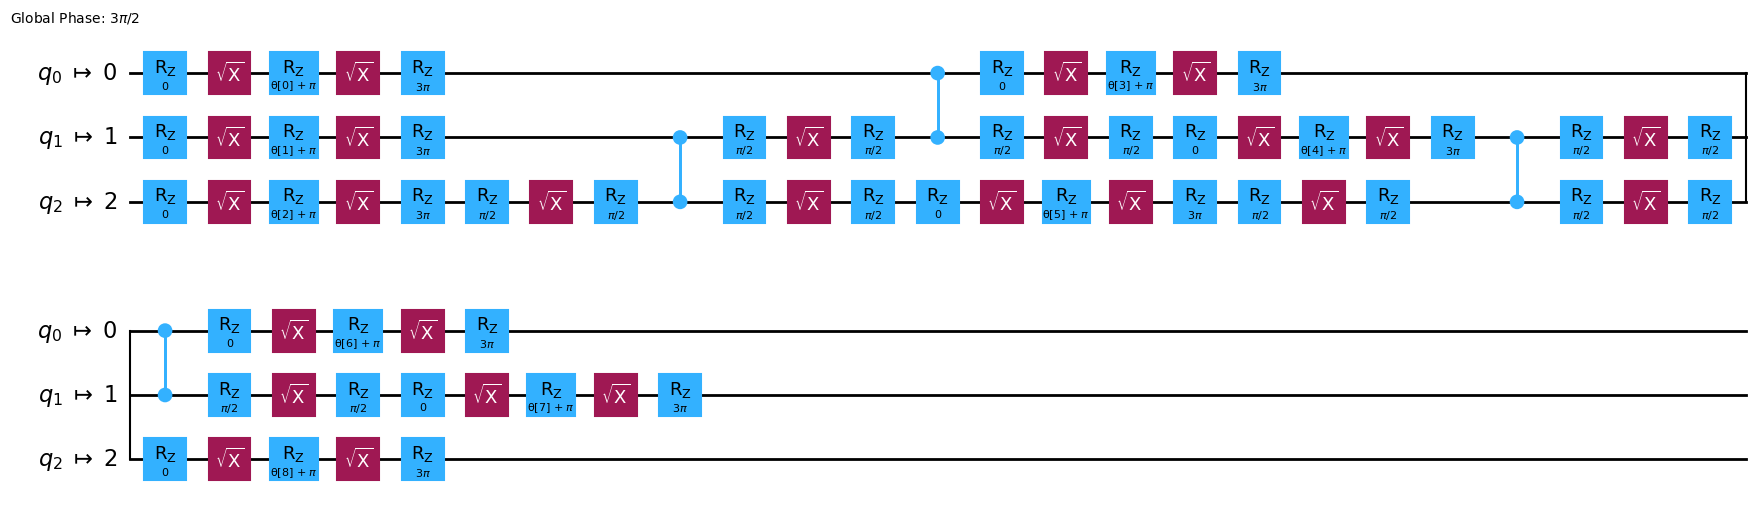

In [33]:
isa_circuit = pass_manager.run(ansatz)
isa_circuit.draw(output="mpl", idle_wires=False)

In [35]:
print("Profondeur du circuit:", isa_circuit.depth())
print("Taille du circuit:", isa_circuit.size())

Profondeur du circuit: 34
Taille du circuit: 73


Ici aussi le `pass_manager` n'a pas d'optimisation. On observe que la taille du circuit est plus grande que pour la feature map. Il faudra être attentif à sa taille car plus la transpilation de l'ansatz sera grande, plus il y aura d'erreur possible lors de l'entraînement du modèle. Nous éviterons donc de prendre un ansatz trop grand.

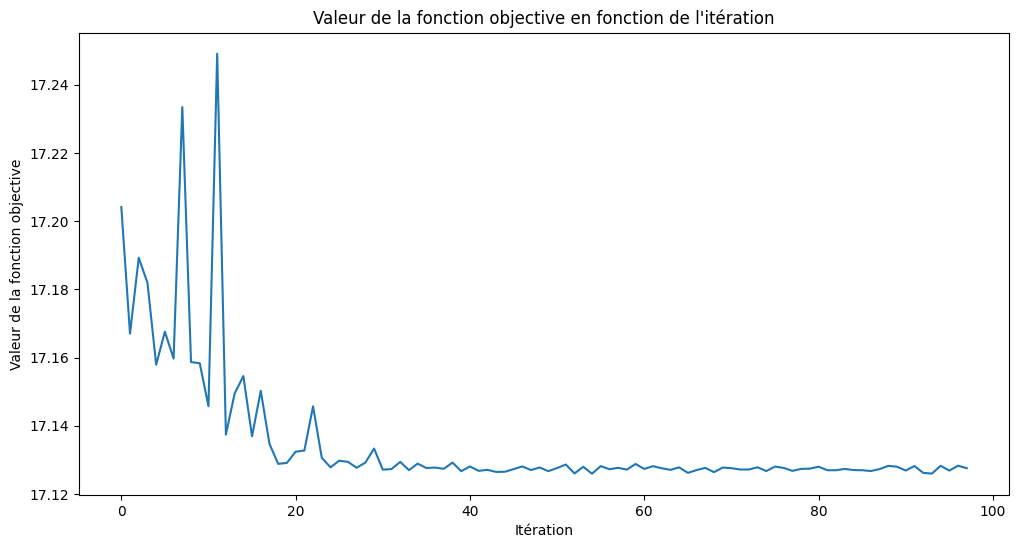

Temps d'entraînement: 2881 secondes


In [89]:
vqc = VQC(
    sampler=sampler,
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=optimizer,
    callback=callback_graph,
    pass_manager=pass_manager,
)

# Nettoyage de l'historique des valeurs de la fonction objective
objective_func_vals = []

start = time.time()
vqc.fit(X_train, np.array(y_train))
elapsed = time.time() - start

print(f"Temps d'entraînement: {round(elapsed)} secondes")

In [91]:
train_score_q4 = vqc.score(X_train, y_train)
test_score_q4 = vqc.score(X_test, y_test)

print(f"Quantum VQC on the training dataset: {train_score_q4:.2f}")
print(f"Quantum VQC on the test dataset:     {test_score_q4:.2f}")

Quantum VQC on the training dataset: 0.40
Quantum VQC on the test dataset:     0.38


Le modèle actuel n'est performant ni sur les données d'entraînement, ni sur les données de test. Nous allons faire en sorte d'optimiser les paramètres afin de rendre le modèle plus performant.

On observe que la convergence se fait assez rapidement. Pour économiser du temps de calcul nous allons garder 50 itérations pour le moment.

## Optimisation de la VQC

### Le pass manager

Avant d'améliorer le circuit nous allons travailler sur la transpilation afin de diminuer les erreurs.

### L'ansatz

Nous allons d'abord optimiser l'ansatz. Jusqu'ici nous avons utilisé un circuit archétype `RealAmplitudes` qui se répétait deux fois. Il va être intéressant de changer cette valeur de répétition. Il sera aussi intéressant de changer d'archétype pour l'ansatz et le remplacer par exemple par un `EfficientSU2` ou un `NLocal`.

#### Différents ansatzes par défaut

On essaye d'abord différents ansatzes par défaut. Avant le des lex exécuter, analysons les un peu ensemble.

##### NLocal

Le NLocal est un circuit utilisé pour la création d'ansatz en VQC. Sa construction est simple et nécessite qu'on lui précise les portes nécessaires pour les rotations et l'intrication. Nous prendrons les portes "rx" pour la rotation et "cz" pour l'intrication car ce sont des portes de bases d'IBM Torino, ce qui facilitera la transpilation et rendra l'ansatz plus _hardware efficient_.


##### RealAmplitudes

##### EfficientSU2

In [37]:
# Palette de couleurs (tu peux changer "tab10" par "Set1", "Accent", etc.)
cmap = plt.get_cmap("tab10")  # Jusqu'à 10 modèles différents facilement

# --- Callback factory ---
def make_callback(model_id, fold_id, objective_func_vals):
    def callback(weights, obj_func_eval):
        clear_output(wait=True)
        print(f"Model {model_id}, Fold {fold_id}, Eval {obj_func_eval}")
        
        objective_func_vals[model_id][fold_id].append(obj_func_eval)

        # Affichage de toutes les courbes
        plt.figure(figsize=(10, 6))
        for i, model_vals in enumerate(objective_func_vals):
            color = cmap(i)  # couleur unique pour chaque modèle
            for j, val_list in enumerate(model_vals):
                label = f"Model {i}, Fold {j}"
                plt.plot(range(len(val_list)), val_list, label=label, color=color)

        plt.title("Évolution de la fonction objective")
        plt.xlabel("Itération")
        plt.ylabel("Valeur de la fonction objective")
        plt.legend()
        plt.grid(True)
        plt.show()
        
    return callback

In [39]:
# --- Cross-validation avec callback adaptée ---
def cross_validation_score(estimator_factory, X, y, model_id, cv=5, objective_func_vals=[]):
    kf = KFold(n_splits=cv, shuffle=True, random_state=42)

    train_scores = []
    test_scores = []

    folds = list(kf.split(X))
    objective_func_vals.append([[] for _ in range(cv)])  # Initialiser les sous-listes pour chaque fold

    for fold_id, (train_index, test_index) in enumerate(folds):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Créer une instance du VQC avec callback spécifique
        vqc = estimator_factory(model_id, fold_id)
        
        vqc.fit(X_train, np.array(y_train))

        train_scores.append(vqc.score(X_train, y_train))
        test_scores.append(vqc.score(X_test, y_test))

    return train_scores, test_scores

In [ ]:
mean_train_scores = {}
mean_test_scores = {}

objective_func_vals = []

ansatzes = [
    # "rx" et "cz" sont prises par défaut, ce sont des portes de base d'IBM Torino
    n_local(num_qubits=feature_dimension, rotation_blocks="rx", entanglement_blocks="cz"),
    real_amplitudes(num_qubits=feature_dimension,),
    efficient_su2(num_qubits=feature_dimension,),
]

optimizer = COBYLA(maxiter=100)

# --- Boucle sur les modèles ---
for model_id, ansatz in enumerate(ansatzes):
    # Réinitialiser le pass manager pour le modèle
    pass_manager = generate_preset_pass_manager(
    backend=fake_backend,
    optimization_level=1,
)

    # Définir une fonction factory qui crée un VQC avec callback personnalisée
    def estimator_factory(model_id=model_id, fold_id=0):
        return VQC(
            sampler=sampler,
            feature_map=feature_map,
            ansatz=ansatz,
            optimizer=optimizer,
            callback=make_callback(model_id, fold_id, objective_func_vals),
            pass_manager=pass_manager,
        )

    train_scores, test_scores = cross_validation_score(
        estimator_factory,
        X, y,
        model_id=model_id,
        cv=5,
        objective_func_vals=objective_func_vals
    )

    mean_train_scores[f"ansatz-{model_id}"] = np.mean(train_scores)
    mean_test_scores[f"ansatz-{model_id}"] = np.mean(test_scores)

In [43]:
print(mean_train_scores)
print(mean_test_scores)

{'ansatz-0': 0.37650236654479763, 'ansatz-1': 0.40002387286797675, 'ansatz-2': 0.41403912489110456}
{'ansatz-0': 0.3843646616541353, 'ansatz-1': 0.3968784461152882, 'ansatz-2': 0.4083972431077695}


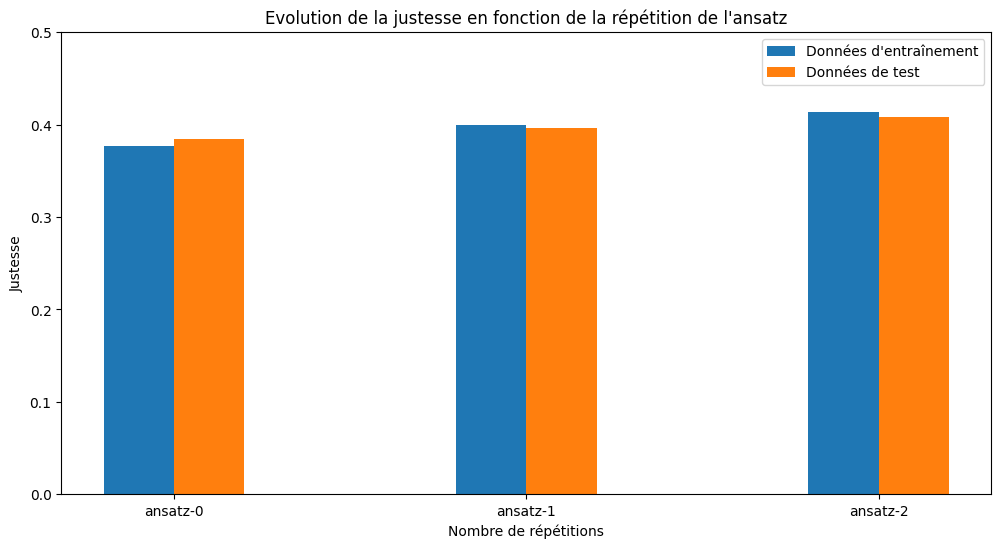

In [55]:
WIDTH = 0.20
plt.bar(np.arange(0, len(mean_train_scores))-WIDTH/2, mean_train_scores.values(), width=WIDTH, label="Données d'entraînement")
plt.bar(np.arange(0, len(mean_train_scores))+WIDTH/2, mean_test_scores.values(), width=WIDTH, label="Données de test")
plt.ylim(0, 0.5)
plt.xticks(np.arange(0, len(mean_train_scores)), mean_test_scores.keys())
plt.ylabel("Justesse")
plt.xlabel("Nombre de répétitions")
plt.title("Evolution de la justesse en fonction de la répétition de l'ansatz")
plt.legend()
plt.show()

On observe que l'ansatz qui a les meilleurs résultats est `EfficientSU`, nous allons créer plusieurs modèles avec cet ansatz, chaque ansatz aura des paramètres différents.

### EfficientSU2

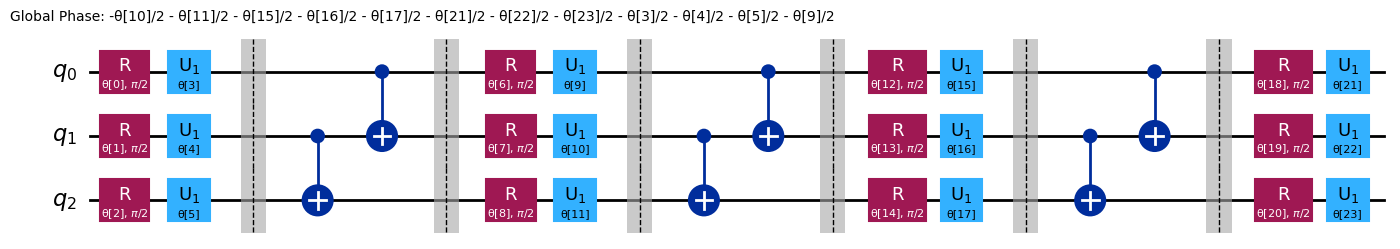

In [41]:
quantum_circuit = efficient_su2(num_qubits=feature_dimension, insert_barriers=True)

quantum_circuit.decompose().draw("mpl")

Regardons en détails l'efffet du paramètre entanglement sur le circuit.

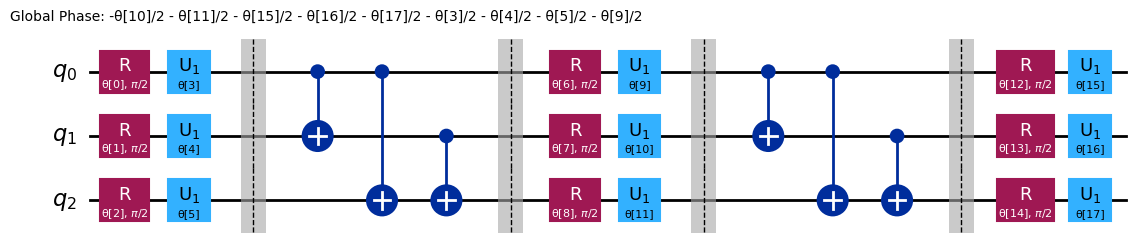

In [44]:
"""
Entanglement peut prendre les valeurs suivantes:
- "full"
- "linear"
- "circular"
- "sca"
- "reverse_linear"
- "pairwise"
"""

full_ansatz = efficient_su2(num_qubits=feature_dimension, entanglement="full", reps=2, insert_barriers=True)
full_ansatz.decompose().draw("mpl")

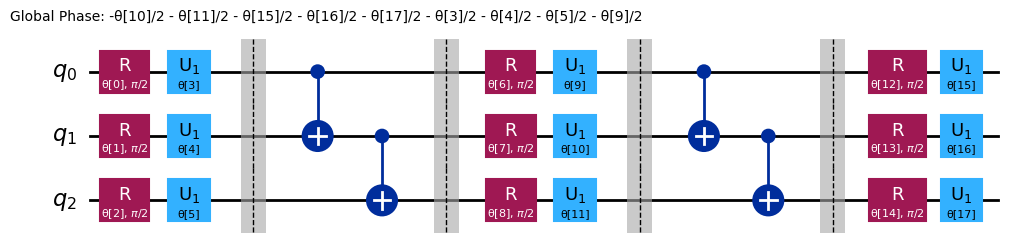

In [46]:
full_ansatz = efficient_su2(num_qubits=feature_dimension, entanglement="linear", reps=2, insert_barriers=True)
full_ansatz.decompose().draw("mpl")

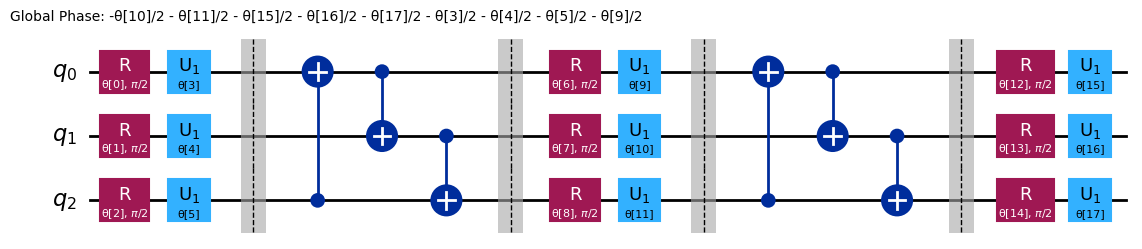

In [48]:
circular_ansatz = efficient_su2(num_qubits=feature_dimension, entanglement="circular", reps=2, insert_barriers=True)
circular_ansatz.decompose().draw("mpl")

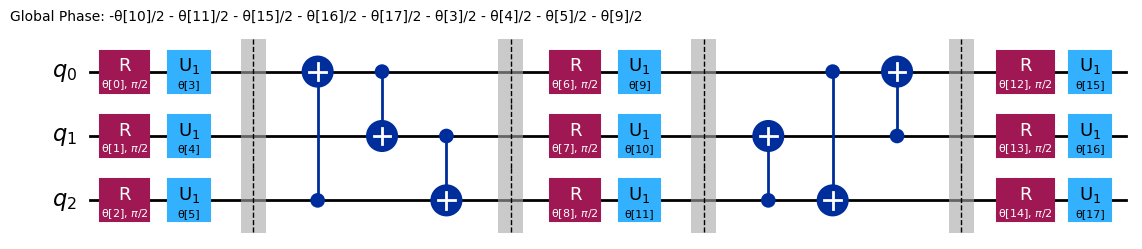

In [50]:
sca_ansatz = efficient_su2(num_qubits=feature_dimension, entanglement="sca", reps=2, insert_barriers=True)
sca_ansatz.decompose().draw("mpl")

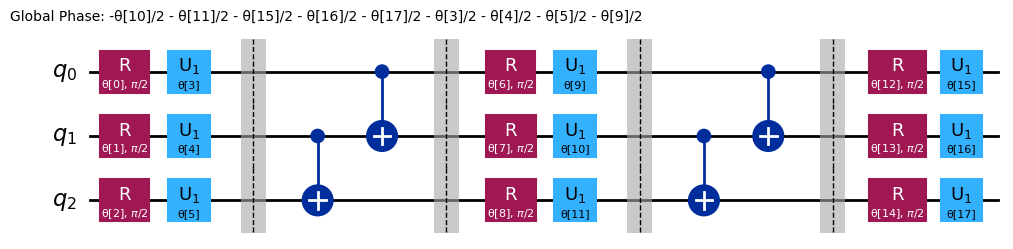

In [52]:
reverse_linear_ansatz = efficient_su2(num_qubits=feature_dimension, entanglement="reverse_linear", reps=2, insert_barriers=True)
reverse_linear_ansatz.decompose().draw("mpl")

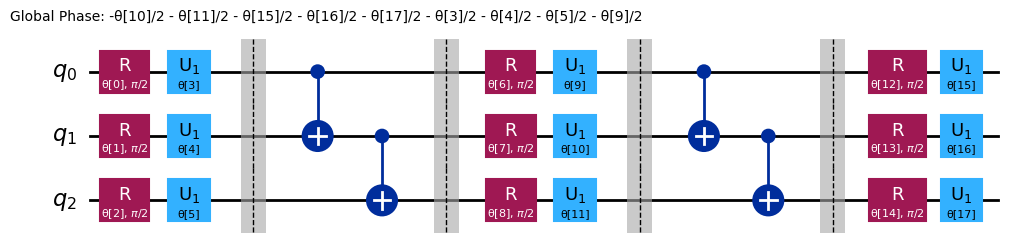

In [54]:
pairwise_ansatz = efficient_su2(num_qubits=feature_dimension, entanglement="pairwise", reps=2, insert_barriers=True)
pairwise_ansatz.decompose().draw("mpl")

On observe que pairwise et linear sont les mêmes.

Model 1, Fold 1, Eval 17.145074835988538


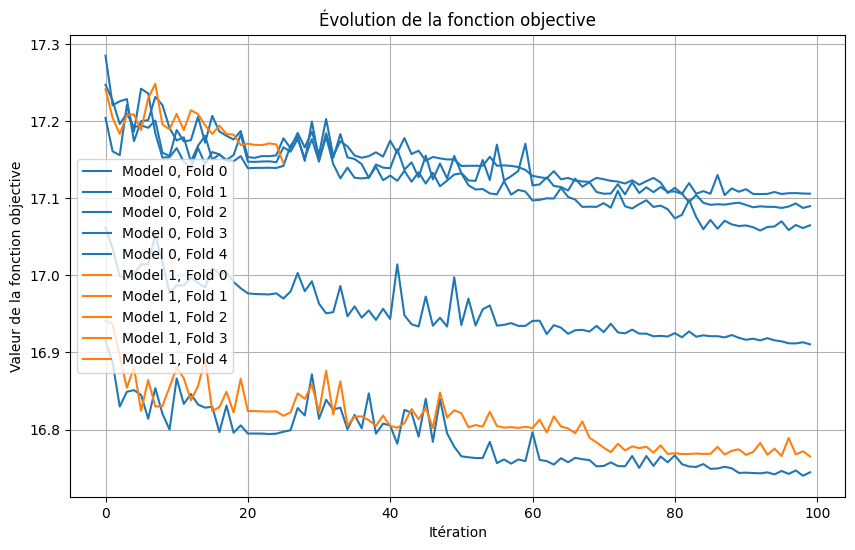

capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


In [ ]:
mean_train_scores = {}
mean_test_scores = {}

objective_func_vals = []

ansatzes = [
    efficient_su2(num_qubits=feature_dimension, entanglement="full"),
    efficient_su2(num_qubits=feature_dimension, entanglement="linear"),
]

optimizer = COBYLA(maxiter=100)

# --- Boucle sur les modèles ---
for model_id, ansatz in enumerate(ansatzes):
    # Réinitialiser le pass manager pour le modèle
    pass_manager = generate_preset_pass_manager(
    backend=fake_backend,
    optimization_level=1,
)

    # Définir une fonction factory qui crée un VQC avec callback personnalisée
    def estimator_factory(model_id=model_id, fold_id=0):
        return VQC(
            sampler=sampler,
            feature_map=feature_map,
            ansatz=ansatz,
            optimizer=optimizer,
            callback=make_callback(model_id, fold_id, objective_func_vals),
            pass_manager=pass_manager,
        )

    train_scores, test_scores = cross_validation_score(
        estimator_factory,
        X, y,
        model_id=model_id,
        cv=5,
        objective_func_vals=objective_func_vals
    )

    mean_train_scores[f"ansatz-{model_id}"] = np.mean(train_scores)
    mean_test_scores[f"ansatz-{model_id}"] = np.mean(test_scores)

#### RealAmplitudes

Analysons dans un premier temps l'ansatz `RealAmplitudes` de manière plus fine. Le circuit prend deux paramètres intéressants qui peuvent jouer sur les performances du modèle.

- `entanglement` : C'est le type d'intrication utilisé
- `reps` : C'est le nombre de fois que le circuit est répété

Regardons l'influence du paramètre `entanglement` sur le circuit en fonction des différentes valeurs qu'il peut prendre.

In [93]:
"""
Entanglement peut prendre les valeurs suivantes:
- "full"
- "linear"
- "circular"
- "sca"
- "reverse_linear"
- "pairwise"
"""

entanglements = ("full", "linear", "circular", "sca", "reverse_linear", "pairwise")

for entanglement in entanglements:
    print(entanglement)
    ansatz = real_amplitudes(
            num_qubits=feature_dimension,
            entanglement=entanglement,
            reps=2
        )
    print(ansatz)

full
     ┌──────────┐          ┌──────────┐                      ┌──────────┐»
q_0: ┤ Ry(θ[0]) ├──■────■──┤ Ry(θ[3]) ├──────────────■────■──┤ Ry(θ[6]) ├»
     ├──────────┤┌─┴─┐  │  └──────────┘┌──────────┐┌─┴─┐  │  └──────────┘»
q_1: ┤ Ry(θ[1]) ├┤ X ├──┼───────■──────┤ Ry(θ[4]) ├┤ X ├──┼───────■──────»
     ├──────────┤└───┘┌─┴─┐   ┌─┴─┐    ├──────────┤└───┘┌─┴─┐   ┌─┴─┐    »
q_2: ┤ Ry(θ[2]) ├─────┤ X ├───┤ X ├────┤ Ry(θ[5]) ├─────┤ X ├───┤ X ├────»
     └──────────┘     └───┘   └───┘    └──────────┘     └───┘   └───┘    »
«                 
«q_0: ────────────
«     ┌──────────┐
«q_1: ┤ Ry(θ[7]) ├
«     ├──────────┤
«q_2: ┤ Ry(θ[8]) ├
«     └──────────┘
linear
     ┌──────────┐     ┌──────────┐                 ┌──────────┐            
q_0: ┤ Ry(θ[0]) ├──■──┤ Ry(θ[3]) ├──────────────■──┤ Ry(θ[6]) ├────────────
     ├──────────┤┌─┴─┐└──────────┘┌──────────┐┌─┴─┐└──────────┘┌──────────┐
q_1: ┤ Ry(θ[1]) ├┤ X ├─────■──────┤ Ry(θ[4]) ├┤ X ├─────■──────┤ Ry(θ[7]) ├
     ├──────────┤└───┘   ┌

Le fait qu'il n'y ait que deux qubits ne change pas les circuits d'un paramètre à l'autre. Nous utiliserons uniquement la valeur `full` comme valeur de référence.

Regardons maintenant l'influence de la répétition.

In [95]:
real_amplitudes_repetitions = range(1, 5)

for repetitions in real_amplitudes_repetitions:
    ansatz = real_amplitudes(
            num_qubits=feature_dimension,
            entanglement=entanglement,
            reps=repetitions
        )
    print(ansatz)

     ┌──────────┐     ┌──────────┐            
q_0: ┤ Ry(θ[0]) ├──■──┤ Ry(θ[3]) ├────────────
     ├──────────┤┌─┴─┐└──────────┘┌──────────┐
q_1: ┤ Ry(θ[1]) ├┤ X ├─────■──────┤ Ry(θ[4]) ├
     ├──────────┤└───┘   ┌─┴─┐    ├──────────┤
q_2: ┤ Ry(θ[2]) ├────────┤ X ├────┤ Ry(θ[5]) ├
     └──────────┘        └───┘    └──────────┘
     ┌──────────┐     ┌──────────┐                 ┌──────────┐            
q_0: ┤ Ry(θ[0]) ├──■──┤ Ry(θ[3]) ├──────────────■──┤ Ry(θ[6]) ├────────────
     ├──────────┤┌─┴─┐└──────────┘┌──────────┐┌─┴─┐└──────────┘┌──────────┐
q_1: ┤ Ry(θ[1]) ├┤ X ├─────■──────┤ Ry(θ[4]) ├┤ X ├─────■──────┤ Ry(θ[7]) ├
     ├──────────┤└───┘   ┌─┴─┐    ├──────────┤└───┘   ┌─┴─┐    ├──────────┤
q_2: ┤ Ry(θ[2]) ├────────┤ X ├────┤ Ry(θ[5]) ├────────┤ X ├────┤ Ry(θ[8]) ├
     └──────────┘        └───┘    └──────────┘        └───┘    └──────────┘
     ┌──────────┐     ┌──────────┐                 ┌──────────┐            »
q_0: ┤ Ry(θ[0]) ├──■──┤ Ry(θ[3]) ├──────────────■──┤ Ry(θ[6]) 

La répétition ajoute des portes quantiques de manière répétitive. Chaque porte de rotation Y correspond à des paramètres d'entraînement du modèle. Plus il y a de répétitions, plus il y a de paramètres, et potentiellement le modèle sera plus précis. Toutefois, plus il y a de portes, plus y aura d'erreurs dans le circuit également. Il faudra donc trouver un juste équilibre entre erreurs de l'ordinateur et nombre de paramètres.

Entraînons des modèles pour différents ansatzes. Nous allons ajouter au passage une validation croisée.

In [ ]:
vqc = VQC(
    sampler=sampler,
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=optimizer,
    callback=callback_graph,
    pass_manager=pass_manager,
)

real_amplitudes_repetitions = range(1, 5)

mean_train_scores = {}
mean_test_scores = {}

for repetitions in real_amplitudes_repetitions:
    ansatz = real_amplitudes(
            num_qubits=feature_dimension,
            entanglement=entanglement,
            reps=repetitions
        )

    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    train_scores = []
    test_scores = []

    for train_index, test_index in tqdm(kf.split(X)):
        X_train, X_test = X.loc[train_index], X.loc[test_index]
        y_train, y_test = y.loc[train_index], y.loc[test_index]

        objective_func_vals = []
        
        vqc.fit(X_train, np.array(y_train))

        train_scores.append(vqc.score(X_train, y_train))
        test_scores.append(vqc.score(X_test, y_test))
    
    mean_train_scores["repetitions-{}".format(str(repetitions))] = np.mean(train_scores)
    mean_test_scores["repetitions-{}".format(str(repetitions))] = np.mean(test_scores)

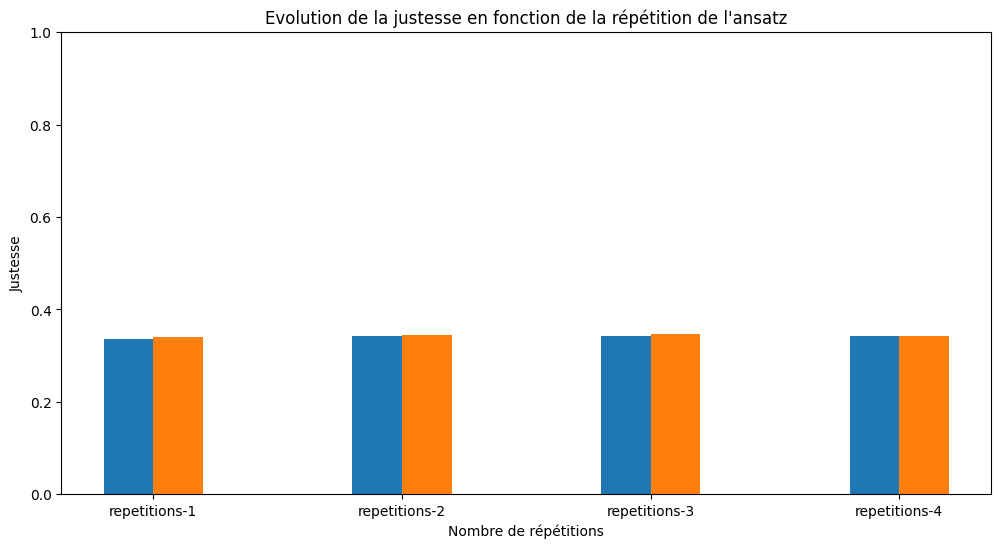

In [88]:
WIDTH = 0.20
plt.bar(np.arange(0,4)-WIDTH/2, mean_train_scores.values(), width=WIDTH, label="Données d'entraînement")
plt.bar(np.arange(0,4)+WIDTH/2, mean_test_scores.values(), width=WIDTH, label="Données de test")
plt.ylim(0, 1)
plt.xticks(np.arange(0, 4), mean_test_scores.keys())
plt.ylabel("Justesse")
plt.xlabel("Nombre de répétitions")
plt.title("Evolution de la justesse en fonction de la répétition de l'ansatz")
plt.show()

In [35]:
def callback_graph(weights, obj_func_eval):
    """
    args:
        weights: Poids calculés
        obj_func_eval: Valeur de la fonction objective
    return: None
    """
    clear_output(wait=True)
    print(objective_func_vals)
    objective_func_vals[len(objective_func_vals) - 1].append(obj_func_eval)
    
    for val_list in objective_func_vals:
        plt.plot(range(len(val_list)), val_list)
    
    plt.title("Valeur de la fonction objective en fonction de l'itération")
    plt.xlabel("Itération")
    plt.ylabel("Valeur de la fonction objective")
    
    plt.show()

In [37]:
def cross_validation_score(estimator, X, y, cv=5, objective_func_vals=[]):
    kf = KFold(n_splits=cv, shuffle=True, random_state=42)
    
    train_scores = []
    test_scores = []
    
    for train_index, test_index in kf.split(X):
        
        objective_func_vals.append([])
        
        X_train, X_test = X.loc[train_index], X.loc[test_index]
        y_train, y_test = y.loc[train_index], y.loc[test_index]
        
        estimator.fit(X_train, np.array(y_train))

        train_scores.append(vqc.score(X_train, y_train))
        test_scores.append(vqc.score(X_test, y_test))
        
        return train_scores, test_scores

In [39]:
optimizer = COBYLA(maxiter=5)

[[0.9406713793690369, 0.9948015111899685, 0.8732978356129231, 0.7802671576036848]]


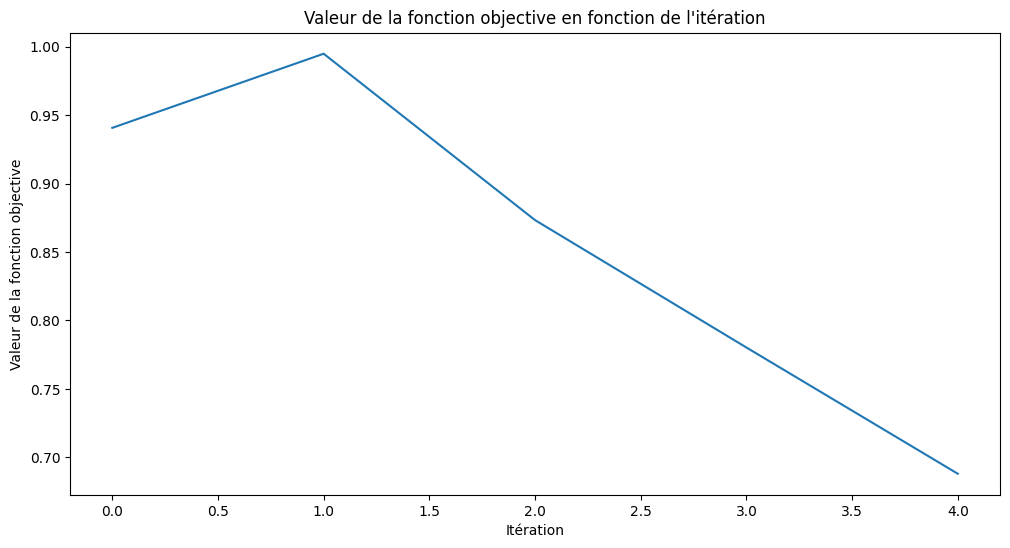

In [41]:
vqc = VQC(
    sampler=sampler,
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=optimizer,
    callback=callback_graph,
    pass_manager=pass_manager,
)

real_amplitudes_repetitions = range(1, 3)

mean_train_scores = {}
mean_test_scores = {}

for repetitions in real_amplitudes_repetitions:
    ansatz = real_amplitudes(
            num_qubits=feature_dimension,
            entanglement="full",
            reps=repetitions
        )
    
    objective_func_vals = []
    
    train_scores, test_scores = cross_validation_score(vqc, X[:4], y[:4], cv=2, objective_func_vals=objective_func_vals)
    
    mean_train_scores["repetitions-{}".format(str(repetitions))] = np.mean(train_scores)
    mean_test_scores["repetitions-{}".format(str(repetitions))] = np.mean(test_scores)

Model 3, Fold 1, Eval 7.46475285897994


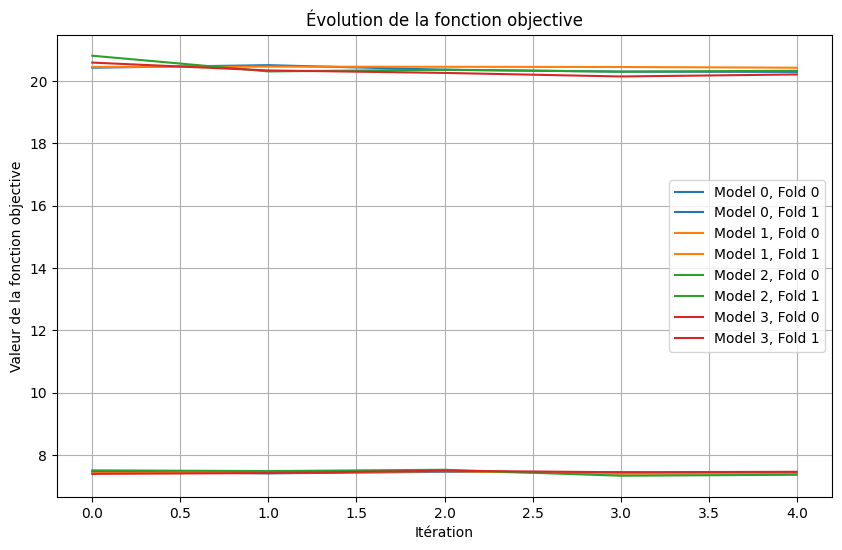

In [68]:
# --- Paramètres globaux ---
optimization_levels = range(0, 4)

mean_train_scores = {}
mean_test_scores = {}

objective_func_vals = []

ansatz = real_amplitudes(
    num_qubits=feature_dimension,
    entanglement="full",
    reps=2
)

optimizer = COBYLA(maxiter=5)

# --- Boucle sur les modèles ---
for model_id, optimization_level in enumerate(optimization_levels):
    # Réinitialiser le pass manager pour le modèle
    pass_manager = generate_preset_pass_manager(
    backend=fake_backend,
    optimization_level=optimization_level,
)

    # Définir une fonction factory qui crée un VQC avec callback personnalisée
    def estimator_factory(model_id=model_id, fold_id=0):
        return VQC(
            sampler=sampler,
            feature_map=feature_map,
            ansatz=ansatz,
            optimizer=optimizer,
            callback=make_callback(model_id, fold_id, objective_func_vals),
            pass_manager=pass_manager,
        )

    train_scores, test_scores = cross_validation_score(
        estimator_factory,
        X[:10], y[:10],
        model_id=model_id,
        cv=2,
        objective_func_vals=objective_func_vals
    )

    mean_train_scores[f"optimization-level-{optimization_level}"] = np.mean(train_scores)
    mean_test_scores[f"optimization_level-{optimization_level}"] = np.mean(test_scores)

{'optimization-level-0': 0.30000000000000004, 'optimization-level-1': 0.2, 'optimization-level-2': 0.4, 'optimization-level-3': 0.4}
{'optimization_level-0': 0.30000000000000004, 'optimization_level-1': 0.2, 'optimization_level-2': 0.4, 'optimization_level-3': 0.2}


Model 0, Fold 4, Eval 16.88387190070681


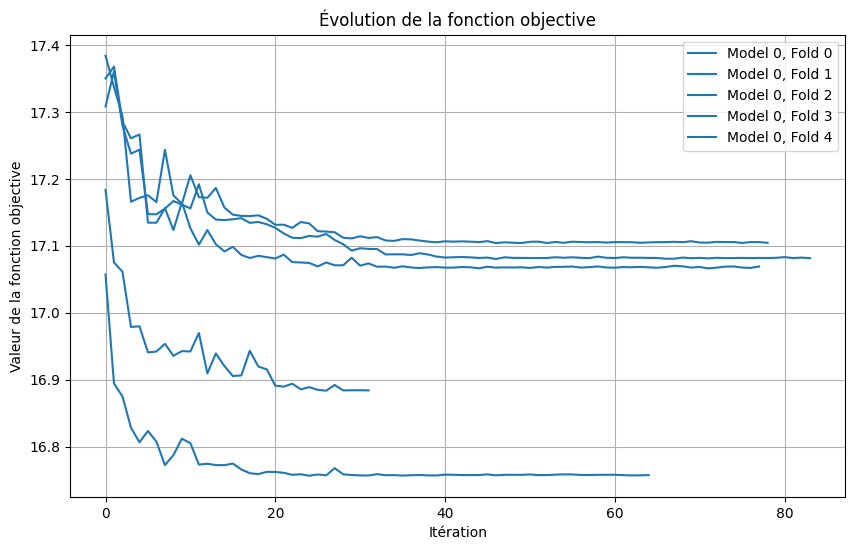

In [47]:
print(mean_train_scores)
print(mean_test_scores)

{'ansatz-0': 0.37549962781807467, 'ansatz-1': 0.42830468980534614, 'ansatz-2': 0.30242524857134584}
{'ansatz-0': 0.3733734335839599, 'ansatz-1': 0.42692230576441104, 'ansatz-2': 0.3003082706766917}


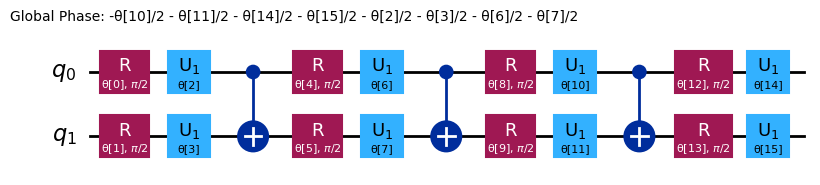

In [43]:
ansatz = efficient_su2(
        num_qubits=feature_dimension,
        entanglement="reverse_linear",
        reps=3
    )
ansatz.decompose().draw(output="mpl")

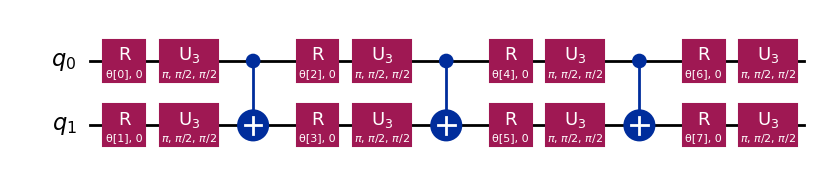

In [49]:
ansatz = efficient_su2(
        num_qubits=feature_dimension,
        entanglement="reverse_linear",
        reps=3,
        su2_gates=["rx", "y"]
    )
ansatz.decompose().draw(output="mpl")

On observe que le type d'intrication ne créer pas de différence entre les circuits. On choisira par défaut la valeur `full`.

In [161]:
from itertools import product
real_amplitudes_repetitions = range(1, 4)
real_amplitudes_repetitions = range(1, 2)

ansatzes = {}
for repetitions in real_amplitudes_repetitions:
    ansatzes["repetitions-{}".format(str(repetitions))] = real_amplitudes(
            num_qubits=feature_dimension,
            entanglement="full",
            reps=repetitions
        )
    
ansatzes

{'repetitions-1': <qiskit.circuit.quantumcircuit.QuantumCircuit at 0x7f1a7f6360d0>}

In [151]:
params = {
    "ansatz": ansatzes
}

for ansatz in ansatzes:
    vqc = VQC(
        sampler=sampler,
        feature_map=feature_map,
        ansatz=ansatz,
        optimizer=optimizer,
        callback=callback_graph,
        pass_manager=pass_manager,
    )

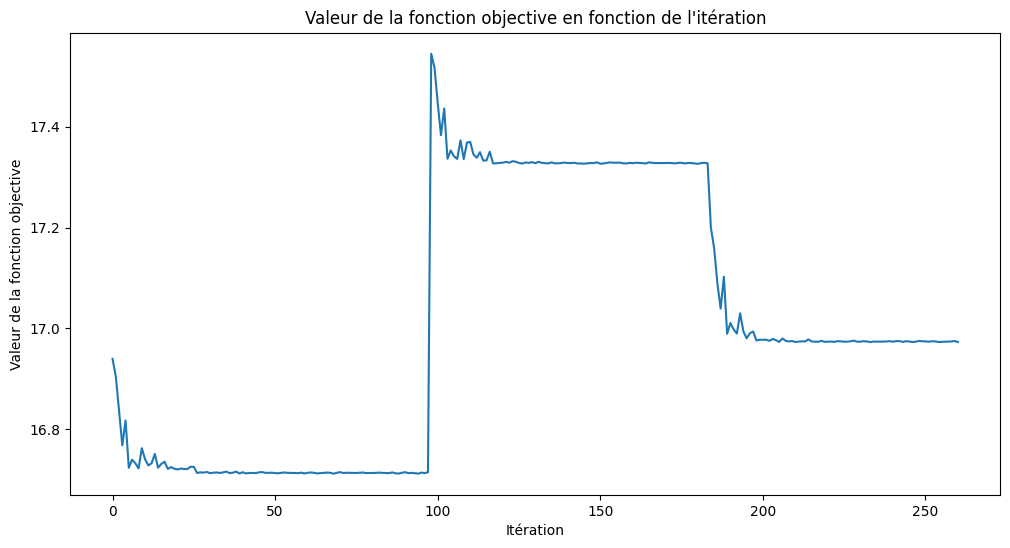

3it [1:36:38, 1932.76s/it]


In [231]:
from sklearn.model_selection import KFold
from tqdm import tqdm
import numpy as np

vqc = VQC(
    sampler=sampler,
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=optimizer,
    callback=callback_graph,
    pass_manager=pass_manager,
)

kf = KFold(n_splits=3, shuffle=True, random_state=42)

train_scores = []
test_scores = []

for train_index, test_index in tqdm(kf.split(X)):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]
    
    vqc.fit(X_train, np.array(y_train))
    
    train_scores.append(vqc.score(X_train, y_train))
    test_scores.append(vqc.score(X_test, y_test))

In [235]:
print(train_scores)
print(test_scores)

[0.3813813813813814, 0.37012012012012013, 0.39714714714714716]
[0.36036036036036034, 0.3888888888888889, 0.3708708708708709]


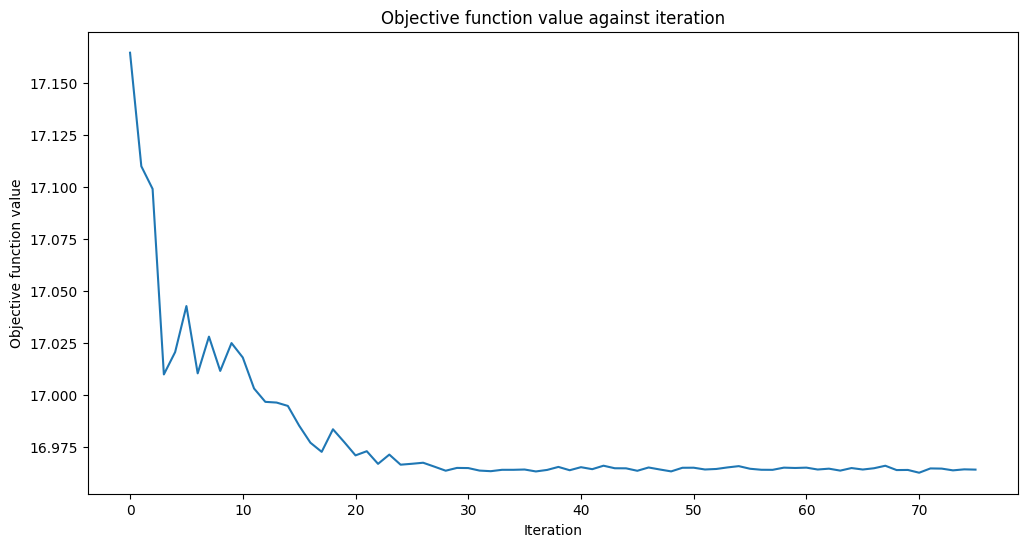

Training time: 1749 seconds


In [134]:
optimization_levels = range(0, 2)

train_scores = []
test_scores = []

for optimization_level in optimization_levels:
    pass_manager = generate_preset_pass_manager(
        backend=fake_backend,
        optimization_level=optimization_level,
    )
    
    vqc = VQC(
        sampler=sampler,
        feature_map=feature_map,
        ansatz=ansatz,
        optimizer=optimizer,
        callback=callback_graph,
        pass_manager=pass_manager,
    )

    # clear objective value history
    objective_func_vals = []

    start = time.time()
    vqc.fit(X_train, np.array(y_train))
    elapsed = time.time() - start

    print(f"Training time: {round(elapsed)} seconds")
    
    train_scores.append(vqc.score(X_train, y_train))
    test_scores.append(vqc.score(X_test, y_test))

In [138]:
print(train_scores)
print(test_scores)

[0.37922403003754696, 0.3848560700876095]
[0.3975, 0.3925]
